In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, Normalizer
sns.set(style="darkgrid")

In [2]:
%run clustering-methods.ipynb

In [3]:
minute_interval = 15
non_reoccuing_number = 100
linkage_methods = ['ward', 'complete', 'average', 'single']
document_features_name = "model-features"
used_features = ['aic','bic','ar_intercept','ar_0', 'ar_2', 'ar_4', 'ar_8', 'ar_12', 'ar_24', 'ar_47']

In [4]:
ts_data = pd.read_csv(f"../../../data/corrected_data_{minute_interval}_{non_reoccuing_number}.csv")

In [5]:
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['ndt'] = pd.to_datetime(ts_data.date) + ts_data.hours.astype('timedelta64[h]') + ts_data.minutes.astype('timedelta64[m]')

In [6]:
features = pd.read_csv(f"../../../data/features_{minute_interval}_{non_reoccuing_number}.csv")
features['non-zero-ratio'] = features['non-zero-occurances'] / features['occurances']
features = features.fillna(0)

In [7]:
features_cl = features.drop(columns=['hash'])

In [8]:
global_date_range = pd.date_range(start=ts_data.date.min().date(), end=ts_data.date.max().date())

## Model features

In [9]:
print(used_features)

['aic', 'bic', 'ar_intercept', 'ar_0', 'ar_2', 'ar_4', 'ar_8', 'ar_12', 'ar_24', 'ar_47']


In [10]:
features_reduced = features_cl[used_features]

In [12]:
r_scaler = StandardScaler().fit(features_reduced)
features_reduced_scaled = r_scaler.transform(features_reduced)
r_normalizer = Normalizer().fit(features_reduced_scaled)
features_rsn = pd.DataFrame(r_normalizer.transform(features_reduced_scaled))
features_rsn.columns = used_features

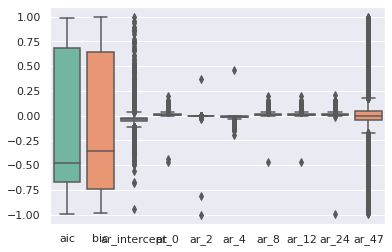

In [13]:
sns.boxplot(data=features_rsn, palette="Set2")

## Method dendograms

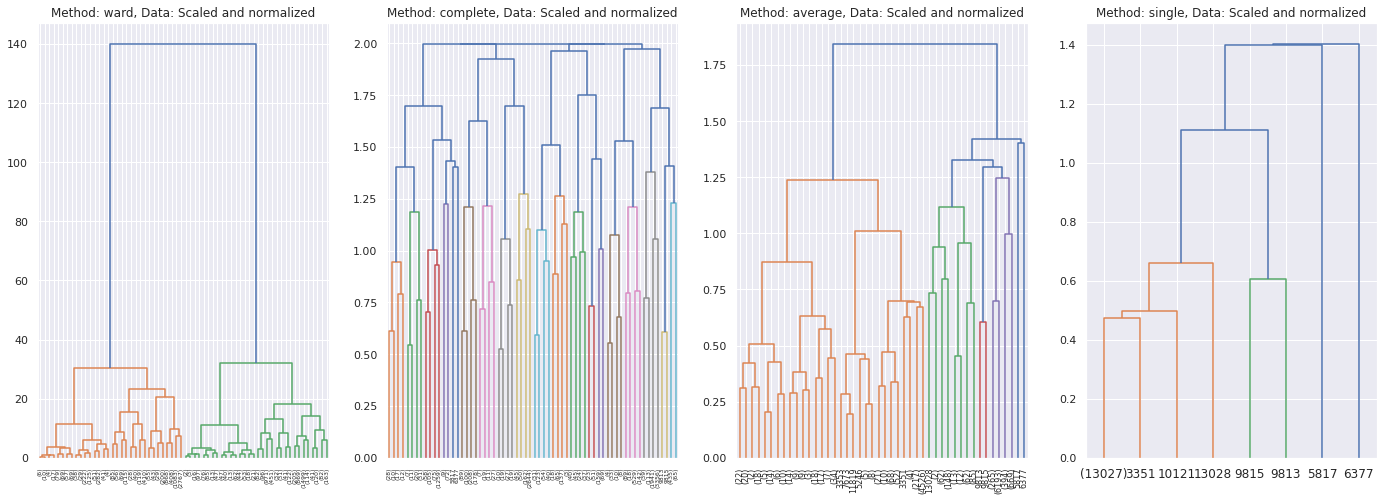

In [14]:
fig, ax = plt.subplots(1, len(linkage_methods))
fig.set_size_inches(24, 8)
for i, method in enumerate(linkage_methods):
    fitted_model = fit_model(features_rsn, method)
    model_dendogram(fitted_model, 5, ax=ax[i])
    ax[i].set_title(f'Method: {method}, Data: Scaled and normalized')

## Single linkage

In [15]:
model_single_rsn = fit_model(features_rsn, 'single', 12, None)
clusters_single_rsn = model_single_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_single_rsn))

[13023     1     1     1     1     1     1     1     1     1     1     1]


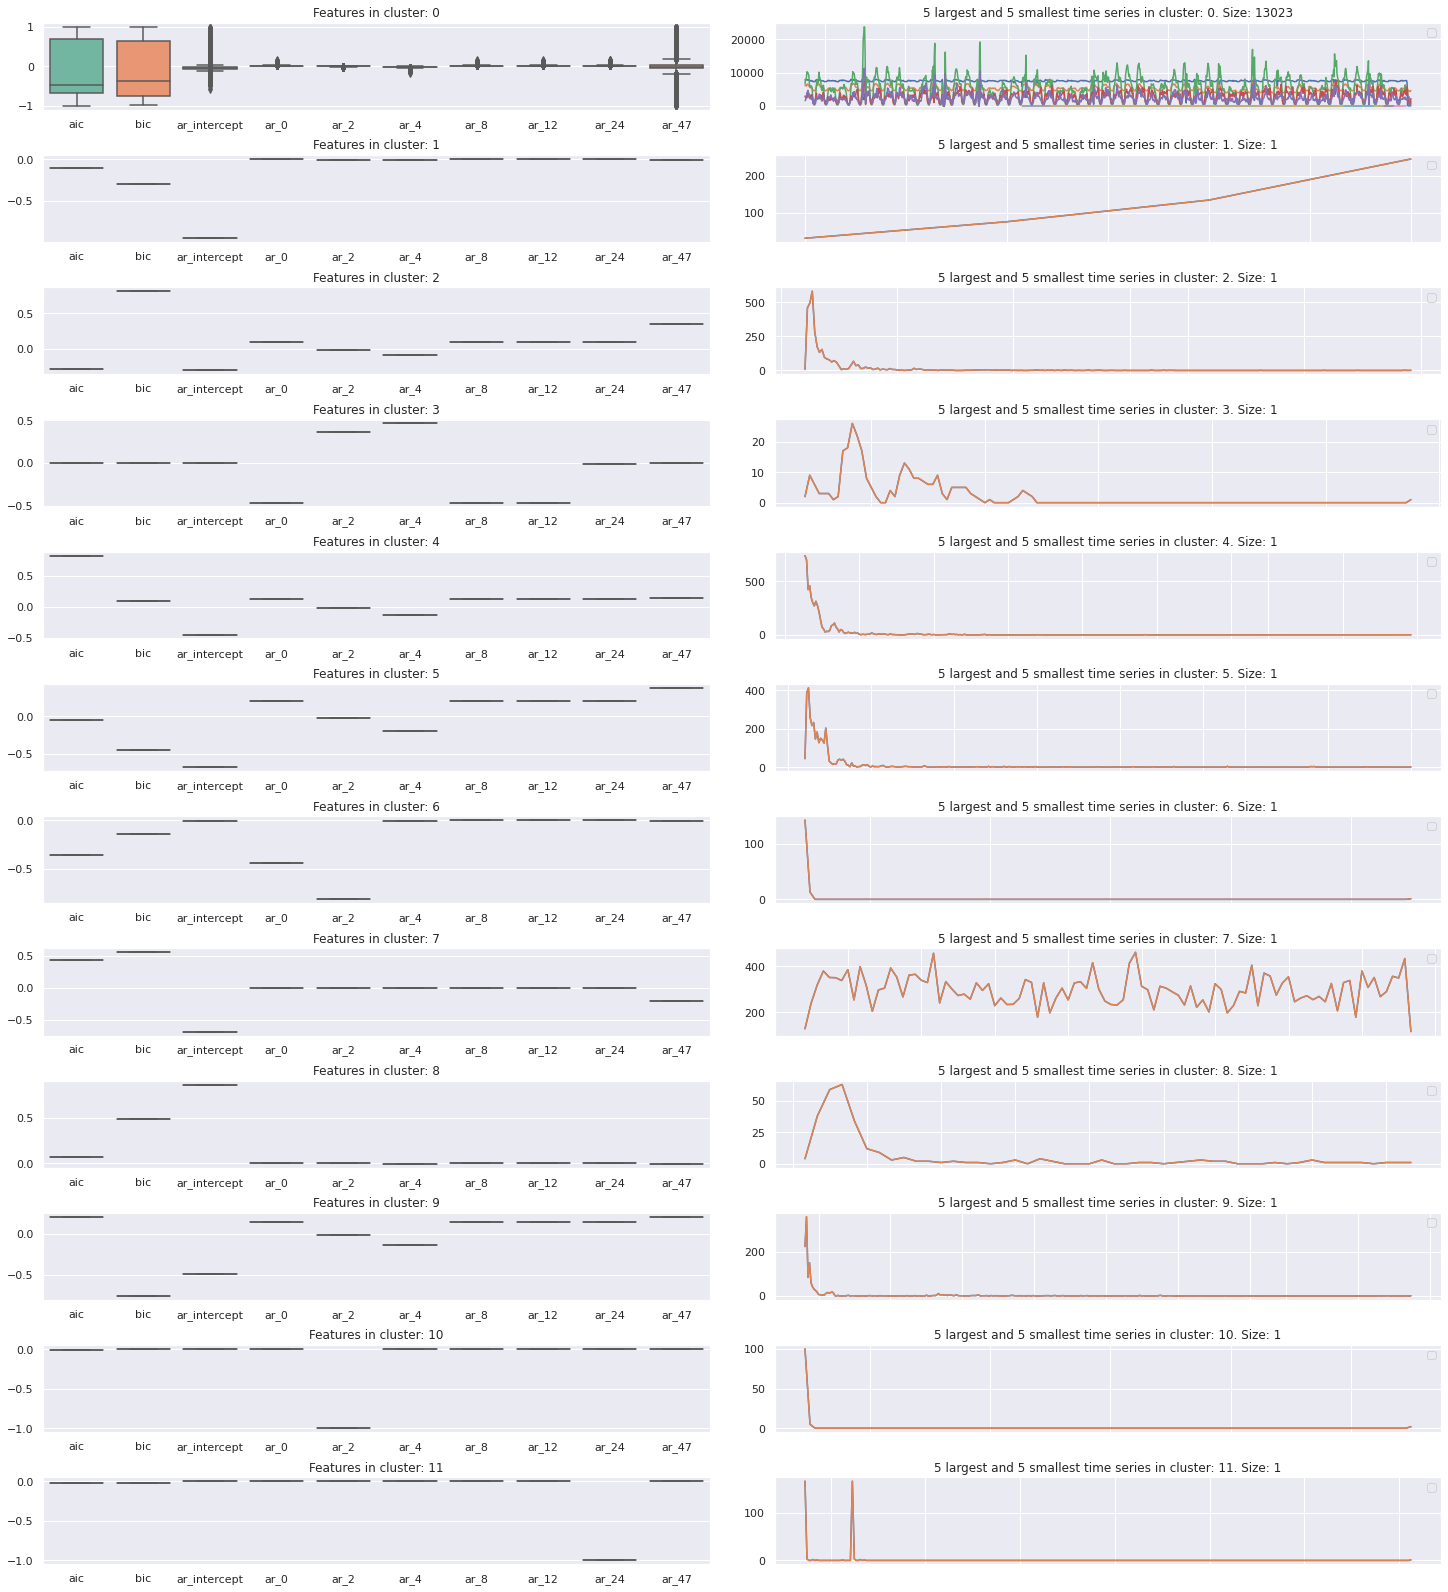

In [17]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_single_rsn, w=20, h=22, boxplot_drop=[])

## Average linkage

In [16]:
model_average_rsn = fit_model(features_rsn, 'average', 12, None)
clusters_average_rsn = model_average_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_average_rsn))

[ 213  669 6458  208 4899   25    2    1  147   17  394    1]


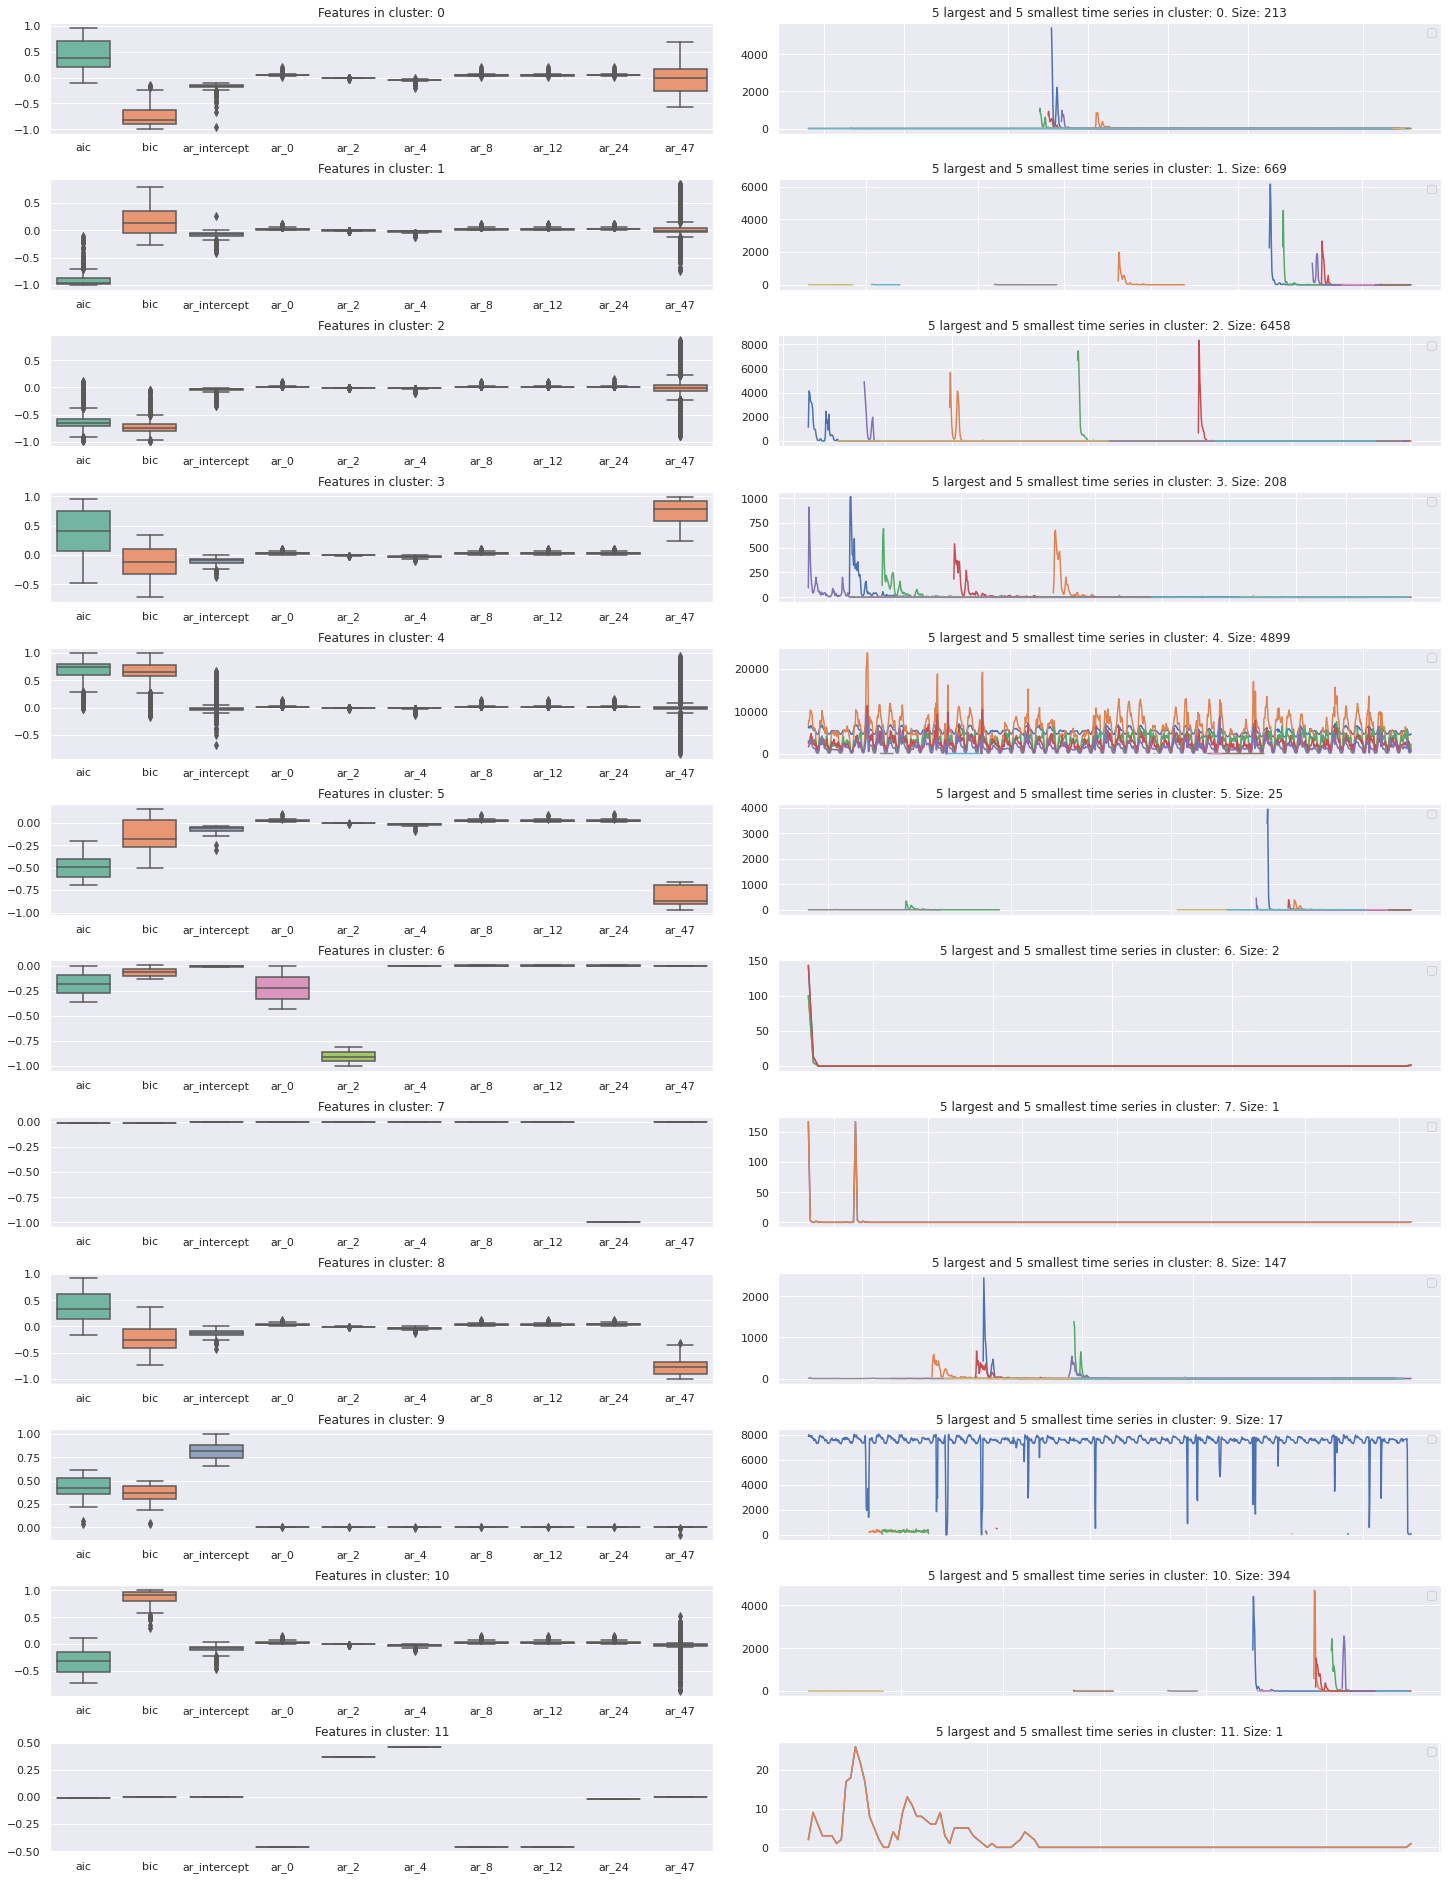

In [19]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_average_rsn, w=20, h=26, boxplot_drop=[])

## Complete linkage

In [17]:
model_complete_rsn = fit_model(features_rsn, 'complete', 12, None)
clusters_complete_rsn = model_complete_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_complete_rsn))

[1580  833  471  302  136   64  502  146   75 2901 5449  575]


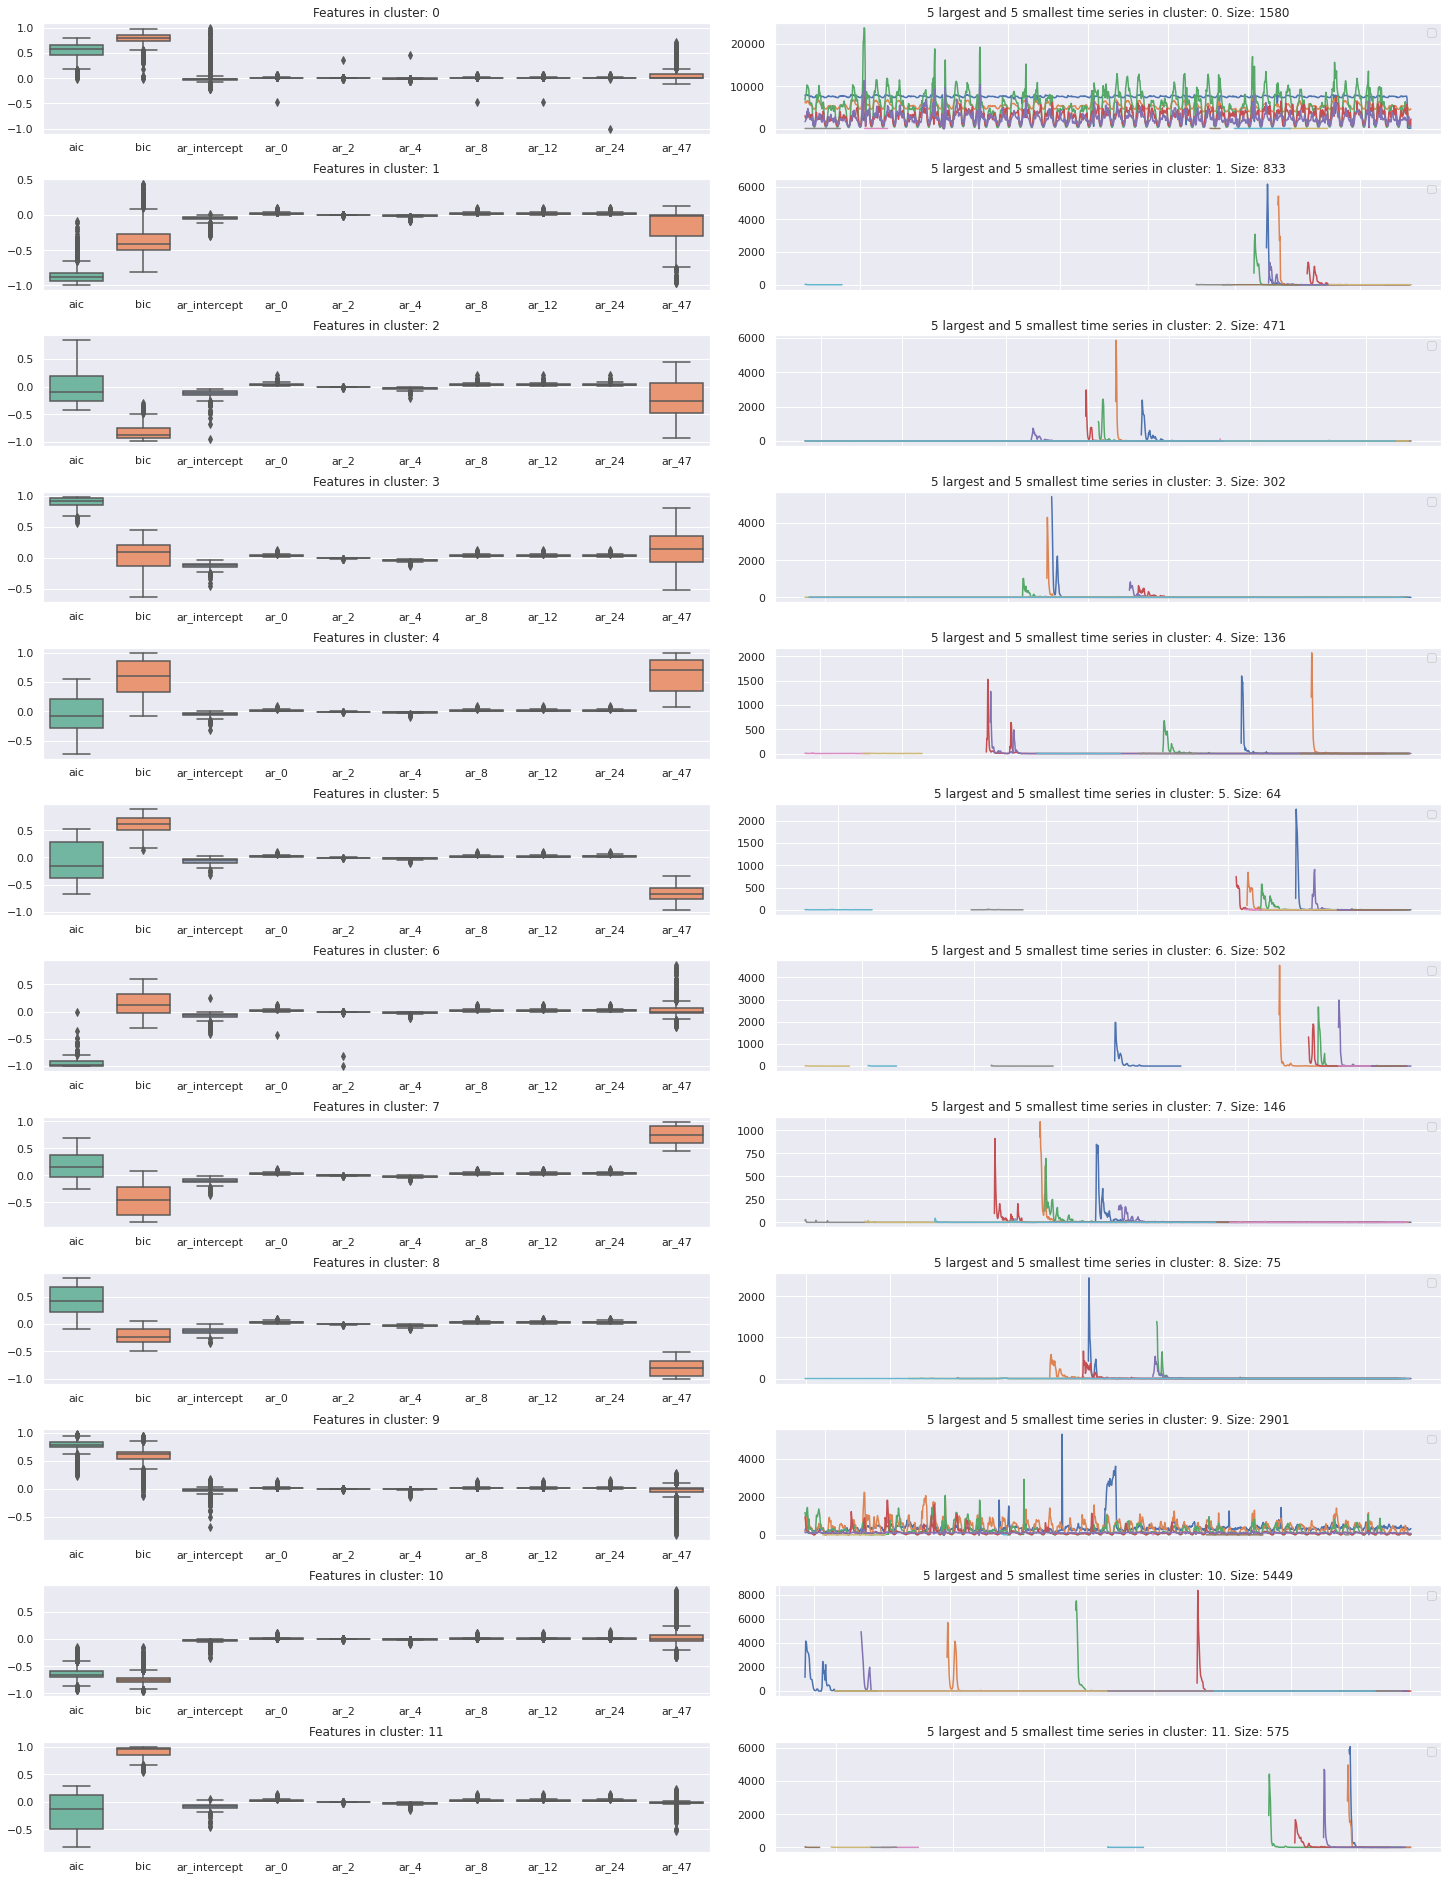

In [21]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_complete_rsn, w=20, h=26, boxplot_drop=[])

## Ward linkage

In [18]:
model_ward_rsn = fit_model(features_rsn, 'ward', 12, None)
clusters_ward_rsn = model_ward_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_ward_rsn))

[ 637 5126  406  325 1600  327  792  226 2687  529   68  311]


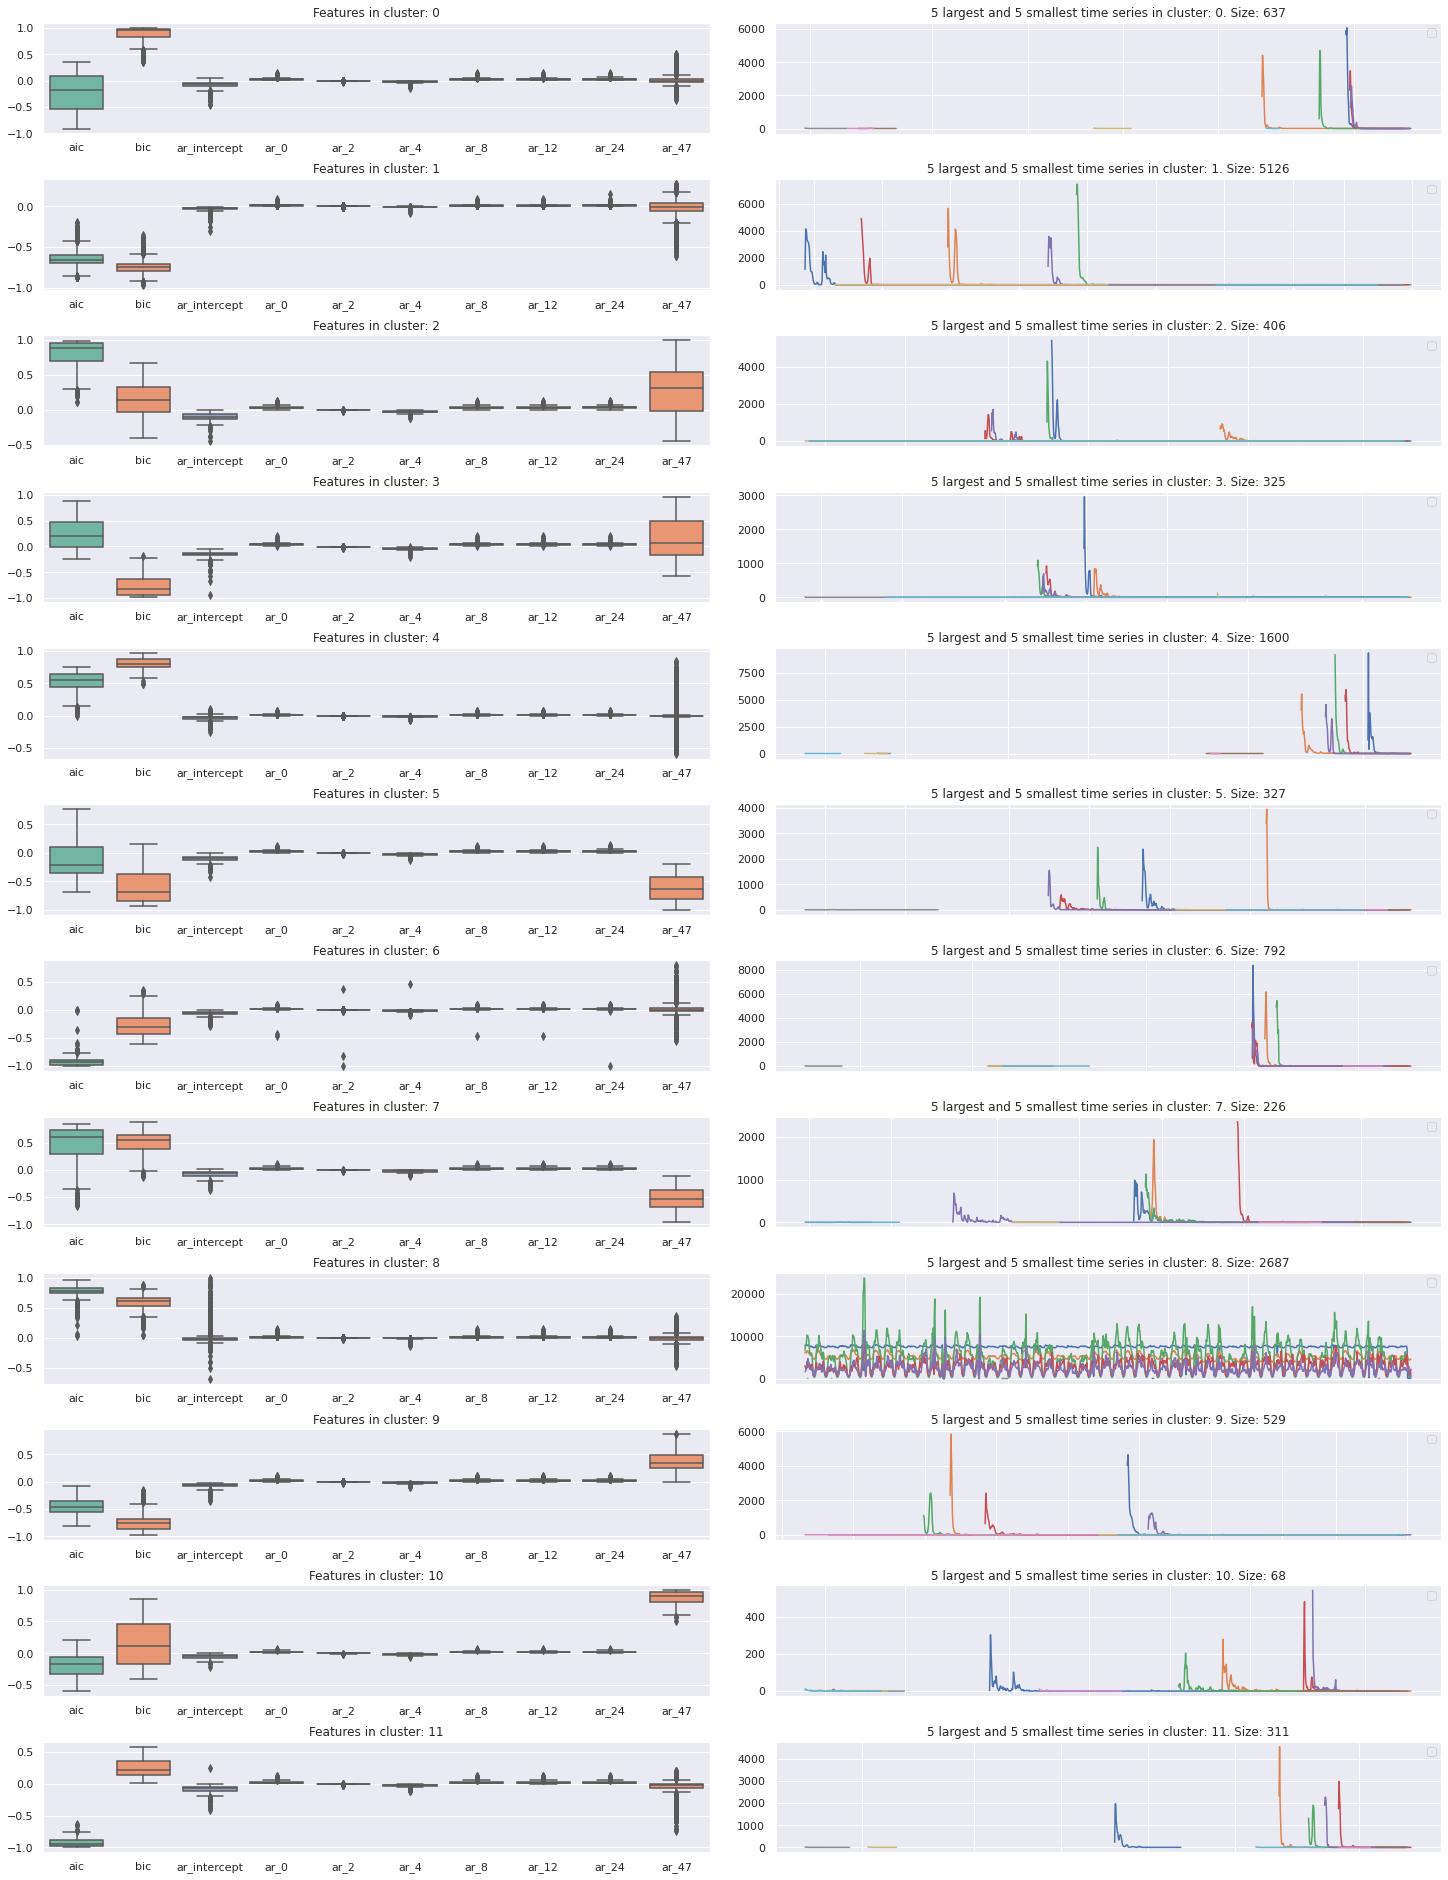

In [23]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_ward_rsn, w=20, h=26, boxplot_drop=[])

## Evaluation

In [24]:
# Single, average, complete, ward
features['rsn_s'] = clusters_single_rsn
features['rsn_a'] = clusters_average_rsn
features['rsn_c'] = clusters_complete_rsn
features['rsn_w'] = clusters_ward_rsn

**Rerunning the notebook might change the order of the clusters hence changing the label. This means this step will need to be redone, changed to match the cluster labels**
**Attempt to assign the same label to similiar clusters**

In [25]:
cluster_evaluation = []
cluster_evaluation_data = []
cluster_group = 'rsn_w'
n_clusters = 12

In [26]:
for cluster_id in range(0, n_clusters):
    group = pd.DataFrame(features.query(f'{cluster_group} == "{cluster_id}"'))
    cluster_evaluation.append(group)
    cluster_evaluation_data.append(ts_data[ts_data['hash'].isin(group['hash'])])

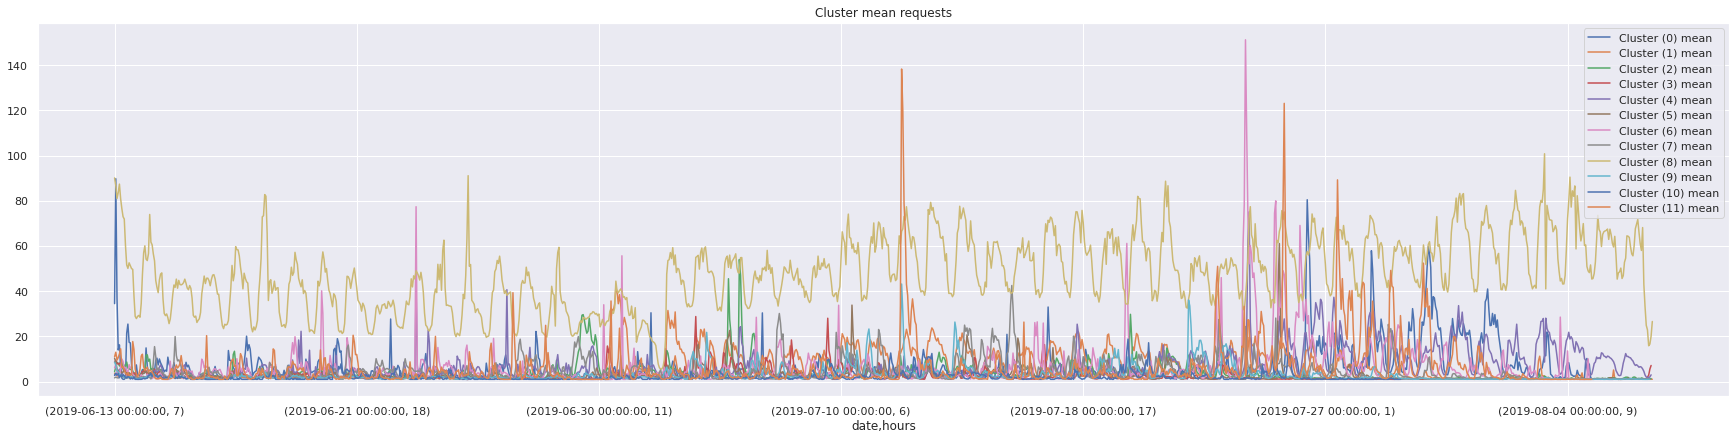

In [27]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 6)
for cluster_id in range(0, n_clusters):
    cluster_evaluation_data[cluster_id].groupby(['date','hours'])['count'].mean().plot(ax=ax, label=f"Cluster ({cluster_id}) mean")
ax.set_title("Cluster mean requests")
ax.legend()

In [28]:
barplot_cluster_lf = pd.DataFrame()
for cluster_id in range(0, n_clusters):
    barplot_cluster_lf[f'Cluster {cluster_id}'] = cluster_evaluation[cluster_id]['lifespan'].value_counts().sort_index().reindex(range(0, max(features['lifespan'].unique())), fill_value=0)

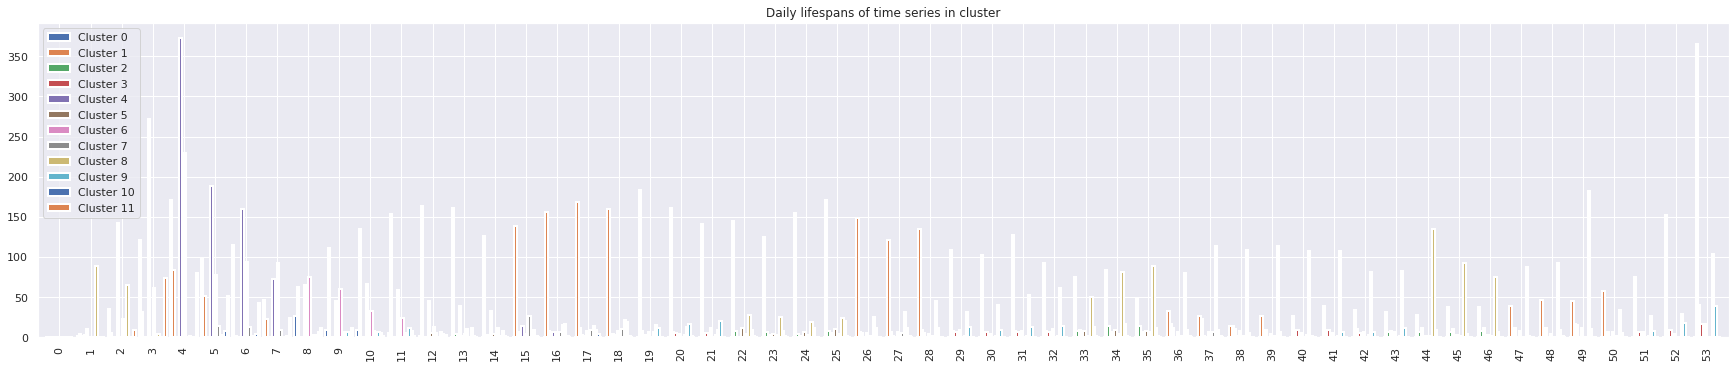

In [29]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 5)
ax.set_title("Daily lifespans of time series in cluster")
barplot_cluster_lf.plot(kind='bar',ax=ax, width=0.9, linewidth=2) #color=['r','b']
ax.legend()

In [30]:
ts_group = ts_data.drop(columns=['hours','minutes']).groupby(['hash','ndt']).sum()

In [31]:
# Disabled to prevent filling RAM
for cluster_id in range(0, n_clusters):
    plot_path = f"../../../plots/{document_features_name}/{cluster_group}-c{cluster_id}"
    os.makedirs(plot_path)
    plot_cluster(cluster_id, ts_group, cluster_evaluation[cluster_id].sort_values('sum'), plot_path)

In [32]:
#!tar -czf ../../plots/c0.tar ../../plots/
#!tar -czf ../../plots/c1.tar ../../plots/c1

/opt/conda/envs/bp/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


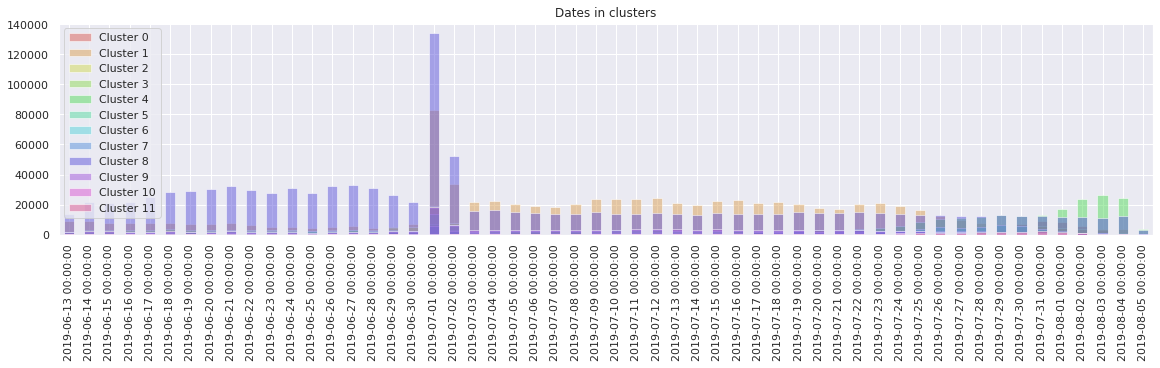

In [33]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(16, 5)
ax.set_title("Dates in clusters")
for cluster_id in range(0, n_clusters):
    ts_data[ts_data['hash'].isin(cluster_evaluation[cluster_id]['hash'])]['date'].value_counts().sort_index()\
                           .plot(kind='bar', alpha=0.5, color=sns.color_palette("hls", n_clusters)[cluster_id], ax=ax, label=f'Cluster {cluster_id}')
ax.legend()